# Graph Neural Networks for Hand Gesture Recognition

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F

import dgl
dgl.load_backend('pytorch')

from dgl.nn.pytorch import SumPooling, MaxPooling, AvgPooling
from dgl.nn.pytorch.conv import GINConv, GATConv

from gnn.dgldataset import HandGestureGraphDataset
from gnn.dataloader import HandGestureDataLoader

%matplotlib inline


## Load Our Dataset

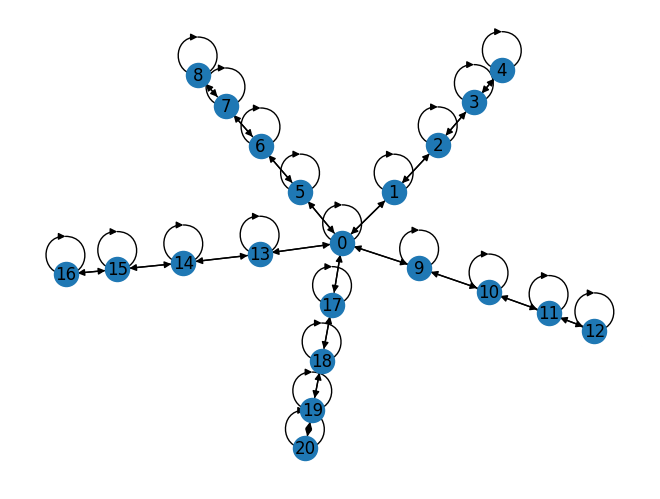

In [2]:
import networkx as nx

# Create the dgl dataset
hand_gesture_dataset = HandGestureGraphDataset()

# Define data loader
hand_gesture_dataloader = HandGestureDataLoader(dataset=hand_gesture_dataset, test_split=0.3, val_split=0.1)
train_loader = hand_gesture_dataloader.get_train_loader()
test_loader = hand_gesture_dataloader.get_test_loader()
val_loader = hand_gesture_dataloader.get_val_loader()

num_node_feature_dim = hand_gesture_dataset.num_node_feature_dim      # Get the number of features for each node - 3
num_classes = hand_gesture_dataset.num_classes                  # Get the number of classes - 36

g = hand_gesture_dataset[0][0]
nx_g = g.to_networkx()

# Plot using NetworkX
nx.draw(nx_g, with_labels=True)

## Draw the different labels of data's distribution

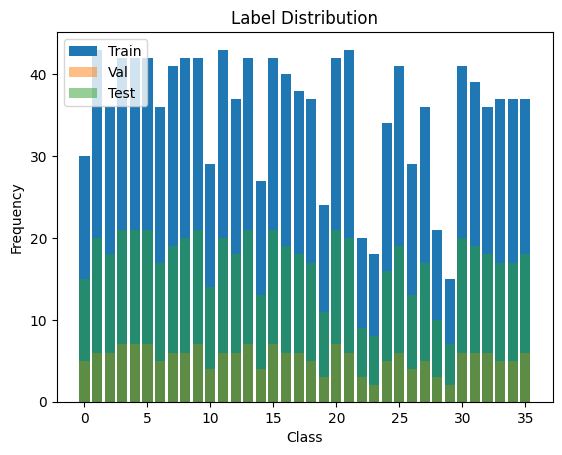

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get the one-hot encoded labels for train, val, and test sets
train_labels = np.vstack([labels.numpy() for _, labels in train_loader])
val_labels = np.vstack([labels.numpy() for _, labels in val_loader])
test_labels = np.vstack([labels.numpy() for _, labels in test_loader])

# Calculate the frequency of each class in the train, val, and test sets
train_class_freq = train_labels.sum(axis=0)
val_class_freq = val_labels.sum(axis=0)
test_class_freq = test_labels.sum(axis=0)

# Plot the label distribution
fig, ax = plt.subplots()
ax.bar(np.arange(num_classes), train_class_freq, label='Train')
ax.bar(np.arange(num_classes), val_class_freq, label='Val', alpha=0.5)
ax.bar(np.arange(num_classes), test_class_freq, label='Test', alpha=0.5)
ax.legend()
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_title('Label Distribution')
plt.show()

## Define train function

In [4]:
def draw_plot(train_losses, val_losses, val_accs, train_accs):
    plt.clf()
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Training Progress')

    axes[0].plot(train_losses, label='Training')
    axes[0].plot(val_losses, label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(val_accs, label='Validation')
    axes[1].plot(train_accs, label='Train')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.show()



def train(model, train_loader, val_loader, lr=0.01, epochs=20):
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs = []
    # Define optimizer and loss function
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = CrossEntropyLoss()

    # Train the model
    epochs = epochs

    for epoch in range(epochs):
        # Set model to the train mode
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0
        # Train on batches
        for batch_idx, (bg, labels) in enumerate(train_loader):
            # Forward pass
            features = bg.ndata['feat']
            logits = model(bg, features)

            # print(logits.size(), labels.size())

            # Compute loss
            loss = criterion(logits, labels)
            total_train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            predicted = torch.argmax(logits, dim=1)
            true_labels = torch.argmax(labels, dim=1)
            total_train_correct += (predicted == true_labels).sum().item()
            total_train_samples += true_labels.shape[0]

        train_acc = total_train_correct / total_train_samples

        # Evaluate on validation set
        model.eval()
        total_val_loss = 0.0
        total_val_acc = 0.0
        with torch.no_grad():
            for batch_idx, (bg, labels) in enumerate(val_loader):
                # Forward pass
                features = bg.ndata['feat']
                logits = model(bg, features)

                # Compute loss
                loss = criterion(logits, labels)
                total_val_loss += loss.item()

                # Compute accuracy
                predicted = torch.argmax(logits, dim=1)
                true_labels = torch.argmax(labels, dim=1)
                # print(f'The predicted is: {predicted}, the true_label is: {true_labels}')
                # print(f'The correct number was: {(predicted == true_labels).sum()}, the number of all candidates is: {len(true_labels)}, the number of val_loader is: {len(val_loader)}')
                total_val_acc += ((predicted == true_labels).sum()).item()

            avg_val_loss = total_val_loss / len(val_loader)
            avg_val_acc = total_val_acc / len(hand_gesture_dataloader.val_indices)

            # Print training and validation loss for the epoch
            print('Epoch {}, Train Accuracy {:.4f}, Train Loss {:.4f}, Val Loss {:.4f}, Val Accuracy {:.4f}'.format(epoch, train_acc,
                                                                                             total_train_loss / len(
                                                                                                 train_loader),
                                                                                             avg_val_loss, avg_val_acc))

            val_losses.append(avg_val_loss)
            train_losses.append(total_train_loss / len(train_loader))
            val_accs.append(avg_val_acc)
            train_accs.append(train_acc)

    draw_plot(train_losses=train_losses, val_losses=val_losses, val_accs=val_accs, train_accs=train_accs)
    return model

## Define test function

In [5]:
def test(model, test_loader):
    criterion = CrossEntropyLoss()
    # Evaluate on test set
    model.eval()
    total_test_loss = 0.0
    total_test_acc = 0.0
    with torch.no_grad():
        for batch_idx, (bg, labels) in enumerate(test_loader):
            # Forward pass
            features = bg.ndata['feat']
            logits = model(bg, features)

            # Compute loss
            loss = criterion(logits, labels)
            total_test_loss += loss.item()

            # Compute accuracy
            predicted = torch.argmax(logits, dim=1)
            true_labels = torch.argmax(labels, dim=1)
            total_test_acc += ((predicted == true_labels).sum()).item()

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_acc = total_test_acc / len(hand_gesture_dataloader.test_indices)

        print('Test Loss {:.4f}, Test Accuracy {:.4f}'.format(avg_test_loss, avg_test_acc))

## Train and test different models

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

### GIN Model

GINModel(
  (ginlayers): ModuleList(
    (0): GINConv(
      (apply_func): MLP(
        (linears): ModuleList(
          (0): Linear(in_features=3, out_features=32, bias=False)
          (1): Linear(in_features=32, out_features=32, bias=False)
        )
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1-3): 3 x GINConv(
      (apply_func): MLP(
        (linears): ModuleList(
          (0-1): 2 x Linear(in_features=32, out_features=32, bias=False)
        )
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (batch_norms): ModuleList(
    (0-3): 4 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_prediction): ModuleList(
    (0): Linear(in_features=3, out_features=36, bias=True)
    (1-4): 4 x Linear(in_features=32, out_features=36, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (pool): SumPo

<Figure size 640x480 with 0 Axes>

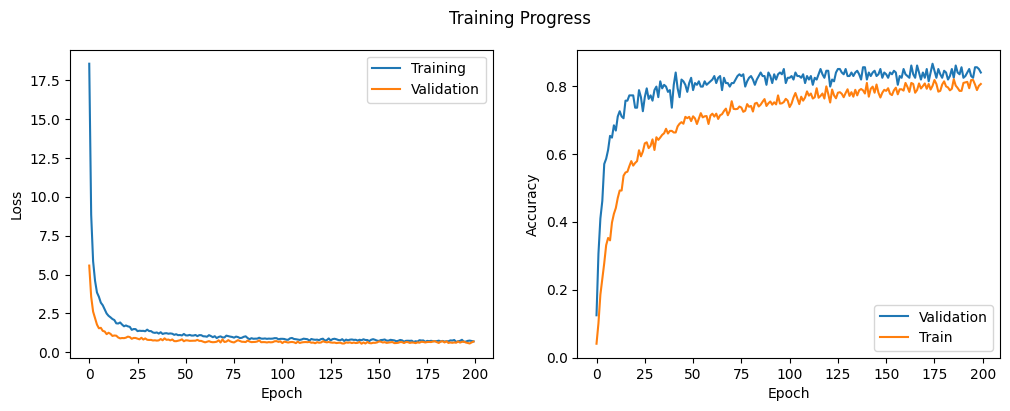

Test Loss 0.6578, Test Accuracy 0.8502


In [25]:
class MLP(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim):
        super().__init__()
        self.linears = nn.ModuleList()
        # two-layer MLP
        self.linears.append(nn.Linear(in_feats, n_hidden, bias=False))
        self.linears.append(nn.Linear(n_hidden, out_dim, bias=False))
        self.xaiver_init()
        self.batch_norm = nn.BatchNorm1d(n_hidden)

    def xaiver_init(self):
        for layer in self.linears:
            nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        h = x
        h = F.relu(self.batch_norm(self.linears[0](h)))
        return self.linears[1](h)

class GINModel(nn.Module):
    def __init__(self, in_feats, n_hidden, out_dim, num_layers):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # GCN with two-layer MLP aggregator and sum-neighbor-pooling scheme
        for layer in range(num_layers - 1):  # excluding the input layer
            if layer == 0:
                mlp = MLP(in_feats, n_hidden, n_hidden)
            else:
                mlp = MLP(n_hidden, n_hidden, n_hidden)
            self.ginlayers.append(
                GINConv(mlp, learn_eps=False)
            )  # set to True if learning epsilon
            self.batch_norms.append(nn.BatchNorm1d(n_hidden))
        # linear functions for graph sum poolings of output of each layer
        self.linear_prediction = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.linear_prediction.append(nn.Linear(in_feats, out_dim))
            else:
                self.linear_prediction.append(nn.Linear(n_hidden, out_dim))
        self.drop = nn.Dropout(0.5)
        self.pool = (
            SumPooling()
        )

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        hidden_rep = [h]
        for i, layer in enumerate(self.ginlayers):
            h = layer(g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)
        score_over_layer = 0
        # perform graph sum pooling over all nodes in each layer
        for i, h in enumerate(hidden_rep):
            pooled_h = self.pool(g, h)
            score_over_layer += self.drop(self.linear_prediction[i](pooled_h))
        return score_over_layer

gin = GINModel(in_feats=num_node_feature_dim, n_hidden=32, out_dim=num_classes, num_layers = 5)

print(gin)

print("parameters: ", count_parameters(gin))

# Train the model
gin_trained_model = train(gin, train_loader, val_loader, lr=0.0005, epochs=200)
# Test the model
test(gin_trained_model, test_loader)

### GIN Model with Residual and Different Pooling (include attention pooling)

parameters:  13856
Epoch 0, Train Accuracy 0.0578, Train Loss 3.6655, Val Loss 3.1953, Val Accuracy 0.2176
Epoch 1, Train Accuracy 0.0960, Train Loss 3.3459, Val Loss 2.9953, Val Accuracy 0.3420
Epoch 2, Train Accuracy 0.1694, Train Loss 3.0837, Val Loss 2.7952, Val Accuracy 0.4197
Epoch 3, Train Accuracy 0.2256, Train Loss 2.9539, Val Loss 2.7197, Val Accuracy 0.4715
Epoch 4, Train Accuracy 0.2334, Train Loss 2.8721, Val Loss 2.5293, Val Accuracy 0.4611
Epoch 5, Train Accuracy 0.2818, Train Loss 2.7253, Val Loss 2.4365, Val Accuracy 0.5233
Epoch 6, Train Accuracy 0.3068, Train Loss 2.6466, Val Loss 2.3783, Val Accuracy 0.5544
Epoch 7, Train Accuracy 0.3201, Train Loss 2.5644, Val Loss 2.2631, Val Accuracy 0.5699
Epoch 8, Train Accuracy 0.3708, Train Loss 2.5024, Val Loss 2.1870, Val Accuracy 0.6269
Epoch 9, Train Accuracy 0.3880, Train Loss 2.4386, Val Loss 2.2194, Val Accuracy 0.6010
Epoch 10, Train Accuracy 0.3997, Train Loss 2.3766, Val Loss 2.0492, Val Accuracy 0.6321
Epoch 11, Tr

<Figure size 640x480 with 0 Axes>

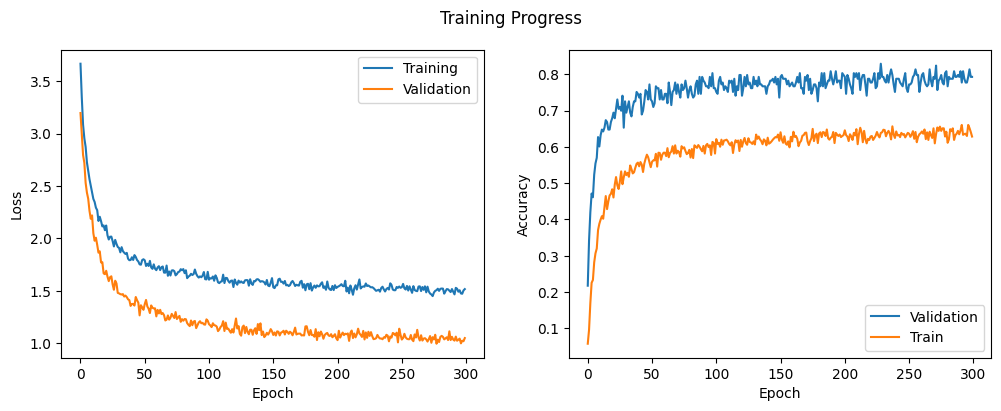

Test Loss 1.0064, Test Accuracy 0.8127


In [26]:
class AttentionSumPooling(nn.Module):
    def __init__(self, in_dim, activation=None):
        super(AttentionSumPooling, self).__init__()
        self.activation = activation
        self.query = nn.Linear(in_dim, 1)

    def forward(self, graph, feat):
        with graph.local_scope():
            # Set the node features for each graph in the batch
            graph.ndata['h'] = feat

            # Compute the attention weights separately for each graph in the batch
            attn_weights = []
            for g in dgl.unbatch(graph):
                h_g = g.ndata['h']
                scores = self.query(h_g)
                attn_weights_g = torch.softmax(scores, dim=0)
                attn_weights.append(attn_weights_g)
            attn_weights = torch.cat(attn_weights)

            # Apply the attention weights to the node features
            feat_weighted = feat * attn_weights

            graph.ndata['h'] = feat_weighted

            # Compute the attention sum pooling for each graph in the batch
            readout = dgl.sum_nodes(graph, 'h')

            # Apply activation function if specified
            if self.activation is not None:
                readout = self.activation(readout)

            return readout


class ATTGINModel(nn.Module):
    def __init__(self, in_feats, n_hidden, out_dim, num_layers, residual=False, pool="sum"):
        super().__init__()
        self.ginlayers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        # add linear tranformation for residual connection
        self.residual1 = nn.Linear(in_feats, n_hidden)
        self.residual2 = nn.Linear(n_hidden, n_hidden)
        self.residual = residual
        self.pool = pool

        # GIN with two-layer MLP aggregator and sum-neighbor-pooling scheme
        for layer in range(num_layers - 1):  # excluding the input layer
            if layer == 0:
                mlp = MLP(in_feats, n_hidden, n_hidden)
            else:
                mlp = MLP(n_hidden, n_hidden, n_hidden)
            self.ginlayers.append(
                GINConv(mlp, learn_eps=False)
            )  # set to True if learning epsilon
            self.batch_norms.append(nn.BatchNorm1d(n_hidden))
        # linear functions for graph sum poolings of output of each layer
        self.linear_prediction = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.linear_prediction.append(nn.Linear(in_feats, out_dim))
            else:
                self.linear_prediction.append(nn.Linear(n_hidden, out_dim))
        self.drop = nn.Dropout(0.5)

    def forward(self, g, h):
        # list of hidden representation at each layer (including the input layer)
        hidden_rep = [h]
        for i, layer in enumerate(self.ginlayers):
            if self.residual:
                h_in = self.residual1(h) if i == 0 else self.residual2(hidden_rep[-1]) # residual connection
                h = layer(g, h) + h_in # add residual connection
            else:
                h = layer(g, h)
            h = self.batch_norms[i](h)
            h = F.relu(h)
            hidden_rep.append(h)
        score_over_layer = 0
        # perform graph attention sum pooling over all nodes in each layer
        for i, h in enumerate(hidden_rep):
            if self.pool == "sum":
                pool = SumPooling()
            elif self.pool == "attn":
                pool = AttentionSumPooling(in_dim=h.shape[1])
            elif self.pool == "max":
                pool = MaxPooling()
            elif self.pool == "avg":
                pool = AvgPooling()
            else:
                pool = SumPooling()

            pooled_h = pool(g, h)

            score_over_layer += self.drop(self.linear_prediction[i](pooled_h))
        return score_over_layer


att_gin = ATTGINModel(in_feats=num_node_feature_dim, n_hidden=32, out_dim=num_classes, num_layers = 5, residual=True, pool="attn")

print("parameters: ", count_parameters(att_gin))

# Train the model
gin_trained_model = train(att_gin, train_loader, val_loader, lr=0.0005, epochs=300)
# Test the model
test(gin_trained_model, test_loader)

### GAT Model

GATModel(
  (conv_layers): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=3, out_features=48, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Linear(in_features=3, out_features=48, bias=False)
    )
    (1-2): 2 x GATConv(
      (fc): Linear(in_features=48, out_features=48, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (res_fc): Identity()
    )
    (3): GATConv(
      (fc): Linear(in_features=48, out_features=216, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
  )
  (bn_layers): ModuleList(
    (0-2): 3 x BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(36, ep

<Figure size 640x480 with 0 Axes>

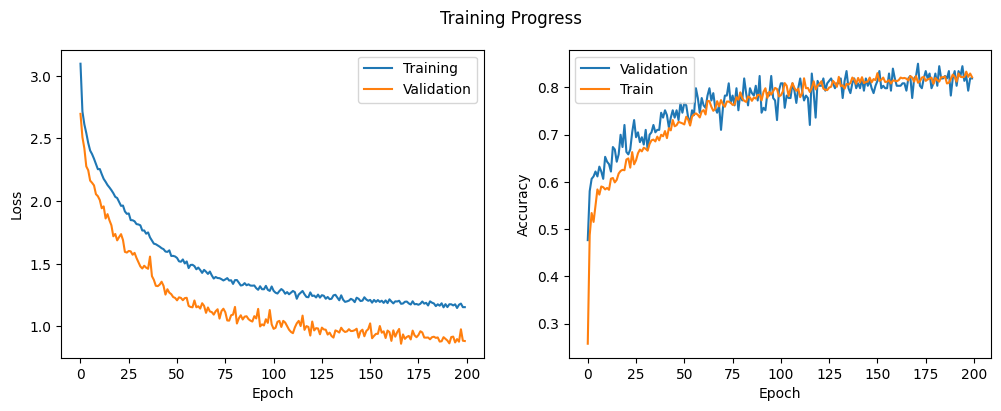

Test Loss 0.8466, Test Accuracy 0.8078


In [29]:
class GATModel(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_heads, n_layers):
        super(GATModel, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.n_layers = n_layers

        self.conv_layers.append(GATConv(in_feats, hidden_feats, num_heads=num_heads, residual=True))
        self.bn_layers.append(nn.BatchNorm1d(hidden_feats * num_heads))

        for i in range(1, n_layers - 1):
            self.conv_layers.append(GATConv(hidden_feats * num_heads, hidden_feats, num_heads=num_heads, residual=True))
            self.bn_layers.append(nn.BatchNorm1d(hidden_feats * num_heads))

        self.conv_layers.append(GATConv(hidden_feats * num_heads, out_feats, num_heads=6))
        self.bn_layers.append(nn.BatchNorm1d(out_feats))

    def forward(self, g, h):
        h = h

        for i in range(self.n_layers - 1):
            h = self.conv_layers[i](g, h).flatten(1)
            h = self.bn_layers[i](h)
            h = F.elu(h)

        h = self.conv_layers[self.n_layers - 1](g, h).mean(1)
        h = self.bn_layers[self.n_layers - 1](h)

        with g.local_scope():
            g.ndata['h'] = h
            hg = dgl.mean_nodes(g, 'h')
            return hg


gat = GATModel(in_feats= num_node_feature_dim, hidden_feats=16, out_feats=num_classes, num_heads=3, n_layers=4)

print(gat)

print("parameters: ", count_parameters(gat))
# Train the model
gat_trained_model = train(gat, train_loader, val_loader, lr=0.001, epochs=200)
# Test the model
test(gat_trained_model, test_loader)